In [1]:
# !pip install torchvision

In [1]:
from torchvision import datasets, transforms, models
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.decomposition import PCA

## 1. Load Data

In [2]:
train_image_dir = "dataset\\train" # path to train images
test_image_dir = "dataset\\test" # path to test images
transform = transforms.Compose([
    transforms.Resize((224, 224,)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Train dataset and dataloader (our candidates)
candidates_dataset = datasets.ImageFolder(train_image_dir, transform=transform)
candidates_loader = torch.utils.data.DataLoader(candidates_dataset, batch_size=64, shuffle=False, num_workers=6)
candidates_path = candidates_dataset.imgs

# Test dataset and dataloader
test_dataset = datasets.ImageFolder(test_image_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
test_path = test_dataset.imgs
print(test_path)

[('dataset\\test\\butterfly\\1001.jpg', 0), ('dataset\\test\\butterfly\\1002.jpg', 0), ('dataset\\test\\butterfly\\1003.jpg', 0), ('dataset\\test\\butterfly\\1004.jpg', 0), ('dataset\\test\\butterfly\\1005.jpg', 0), ('dataset\\test\\butterfly\\1006.jpg', 0), ('dataset\\test\\butterfly\\1007.jpg', 0), ('dataset\\test\\butterfly\\1008.jpg', 0), ('dataset\\test\\butterfly\\1009.jpg', 0), ('dataset\\test\\butterfly\\1010.jpg', 0), ('dataset\\test\\butterfly\\1011.jpg', 0), ('dataset\\test\\butterfly\\1012.jpg', 0), ('dataset\\test\\butterfly\\1013.jpg', 0), ('dataset\\test\\butterfly\\1014.jpg', 0), ('dataset\\test\\butterfly\\1015.jpg', 0), ('dataset\\test\\butterfly\\1016.jpg', 0), ('dataset\\test\\butterfly\\1017.jpg', 0), ('dataset\\test\\butterfly\\1018.jpg', 0), ('dataset\\test\\butterfly\\1019.jpg', 0), ('dataset\\test\\butterfly\\1020.jpg', 0), ('dataset\\test\\butterfly\\1021.jpg', 0), ('dataset\\test\\butterfly\\1022.jpg', 0), ('dataset\\test\\butterfly\\1023.jpg', 0), ('dataset\

## 2. Load pre-trained ResNet Model

In [3]:
# Use gpu if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use pretrained ResNet model
net = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
# Create a new network without the fully connected layers
net = torch.nn.Sequential(*(list(net.children())[:-1]))
net.eval() 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## 3. Calculate the features for the candidates



In [12]:
candidates = []
for data in test_loader:
    image, label = data
    image = image.to(device)
    output = net(image)
    output = output.detach().cpu().numpy().reshape(-1,
    np.prod(output.size()[1:]))
    candidates.append(output)
candidates = np.concatenate(candidates)

In [13]:
for c in candidates:
    print(candidates)

[[8.7864250e-02 5.1543418e-02 7.0926958e-01 ... 6.2176377e-02
  2.3082538e-01 3.5782045e-01]
 [4.4694495e-01 6.0797763e-01 3.7574461e-01 ... 7.0449495e-04
  1.5971021e-01 7.6388842e-01]
 [1.3781080e-03 6.0349381e-01 1.7392209e-01 ... 2.7437693e-01
  1.7560343e-01 2.8944644e-01]
 ...
 [9.6921571e-02 3.3932731e-01 5.2468532e-01 ... 1.7540573e-01
  3.0606180e-01 2.4482703e-01]
 [6.9191796e-01 2.4318968e-01 5.7737887e-01 ... 5.9624332e-01
  4.9818534e-02 2.6298413e-01]
 [1.0681637e-01 3.4756100e-01 4.6853885e-01 ... 5.4394108e-01
  6.5309882e-02 4.0394273e-01]]
[[8.7864250e-02 5.1543418e-02 7.0926958e-01 ... 6.2176377e-02
  2.3082538e-01 3.5782045e-01]
 [4.4694495e-01 6.0797763e-01 3.7574461e-01 ... 7.0449495e-04
  1.5971021e-01 7.6388842e-01]
 [1.3781080e-03 6.0349381e-01 1.7392209e-01 ... 2.7437693e-01
  1.7560343e-01 2.8944644e-01]
 ...
 [9.6921571e-02 3.3932731e-01 5.2468532e-01 ... 1.7540573e-01
  3.0606180e-01 2.4482703e-01]
 [6.9191796e-01 2.4318968e-01 5.7737887e-01 ... 5.9624332e-

## 4. Fit the candidates

In [14]:
k = 10
# knn = NearestNeighbors(n_neighbors=k, metric="cosine")
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

knn.fit(candidates)

NearestNeighbors(metric='euclidean', n_neighbors=10)

## 5. Start predicting!



In [15]:
def predict(test_loader):
    
    res = []
    for i, data in enumerate(test_loader):
        image, label = data
        image = image.to(device)
        output = net(image)
        output = output.detach().cpu().numpy().reshape(-1,
        np.prod(output.size()[1:]))
        
        _, neighbors_idx = knn.kneighbors(output)
        res.append((test_dataset.imgs[i][0], neighbors_idx[0],))
    return res
res = predict(test_loader)
print(res)

[('dataset\\test\\butterfly\\1001.jpg', array([ 0, 45, 69, 74, 54, 59, 37, 99, 20, 25], dtype=int64)), ('dataset\\test\\butterfly\\1002.jpg', array([  1,  20,  38,  73,  11,  31, 825,  27,  76,  58], dtype=int64)), ('dataset\\test\\butterfly\\1003.jpg', array([ 2, 56, 96, 38, 58, 90, 99, 42, 71, 16], dtype=int64)), ('dataset\\test\\butterfly\\1004.jpg', array([ 3, 97, 76, 38, 31, 10, 16, 89, 58, 22], dtype=int64)), ('dataset\\test\\butterfly\\1005.jpg', array([ 4, 58,  2, 71, 60, 74, 62, 86, 99, 52], dtype=int64)), ('dataset\\test\\butterfly\\1006.jpg', array([  5, 316,  19, 940, 930, 907,  65, 517, 971, 698], dtype=int64)), ('dataset\\test\\butterfly\\1007.jpg', array([ 6,  8, 56, 10, 62, 20, 36, 61, 38, 99], dtype=int64)), ('dataset\\test\\butterfly\\1008.jpg', array([ 7, 39, 85, 45, 27, 54, 61, 20, 52, 60], dtype=int64)), ('dataset\\test\\butterfly\\1009.jpg', array([ 8, 99, 85,  6, 58, 56, 74, 84, 22, 10], dtype=int64)), ('dataset\\test\\butterfly\\1010.jpg', array([ 9, 72, 40, 79,

In [8]:
print(res)

[('dataset\\test\\butterfly\\1001.jpg', array([369, 876, 734, 623, 613, 601, 580, 994, 790, 989], dtype=int64)), ('dataset\\test\\butterfly\\1002.jpg', array([143, 505, 678,  85, 104, 388, 486, 954,  26, 927], dtype=int64)), ('dataset\\test\\butterfly\\1003.jpg', array([ 84, 295, 884, 421, 273, 596,  56, 303,  75, 413], dtype=int64)), ('dataset\\test\\butterfly\\1004.jpg', array([296, 194, 405, 619, 430,  40, 665, 242, 628, 417], dtype=int64)), ('dataset\\test\\butterfly\\1005.jpg', array([197,  47, 135,  68, 223,  84, 514, 893, 487, 959], dtype=int64)), ('dataset\\test\\butterfly\\1006.jpg', array([5750, 9796,  981, 5765, 9983, 5237, 3455, 9748, 9163, 9398],
      dtype=int64)), ('dataset\\test\\butterfly\\1007.jpg', array([121, 348, 551, 559, 394, 123, 437, 721, 643, 292], dtype=int64)), ('dataset\\test\\butterfly\\1008.jpg', array([211, 598, 290, 219, 790, 346, 710, 274, 992, 752], dtype=int64)), ('dataset\\test\\butterfly\\1009.jpg', array([169, 721, 237, 123, 583,  93, 507, 471, 2

C:\Users\user\AppData\Local\Temp\ipykernel_11768\3746461689.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], cmap='viridis', s=50)


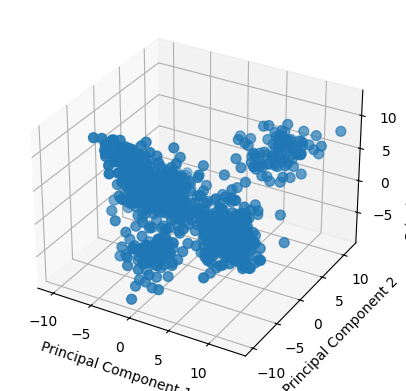

In [16]:
def visualize_features_3d(features):
    pca = PCA(n_components=3)
    reduced_features = pca.fit_transform(features)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], cmap='viridis', s=50)
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    plt.show()


# 提取所有圖片的特徵向量
all_features = []
for i, data in enumerate(test_loader):
    image, _ = data
    image = image.to(device)
    output = net(image)
    output = output.detach().cpu().numpy().reshape(-1, np.prod(output.size()[1:]))
    all_features.append(output)

all_features = np.vstack(all_features)
visualize_features_3d(all_features)

In [17]:
def plot_result(query_image, candidates_idx, candidates_path):
    plt.figure(figsize=(20,10))
    columns = 5
    # show query image
    image = Image.open(query_image)
    image = np.asarray(image)
    ax = plt.subplot(3, columns, 1)
    ax.set_title(f"Query: {query_image.split('/')[-1]}")
    plt.imshow(image)
    for i, idx in enumerate(candidates_idx):
        image_path = candidates_path[idx][0]
        image = Image.open(image_path)
        image = np.asarray(image)
        ax = plt.subplot(3, columns, i + 1 + 5)
        ax.set_title(image_path.split("/")[-1])
        plt.imshow(image)   
    plt.show()

In [32]:
def evaluate_precision(res, test_path):
    total_precision = 0
    for i in range(0, 1000, 100):
        random_index = np.random.randint(i, i+100)
        test_image_path, candidates_idx = res[random_index]
        now_label = test_image_path.split('\\')[-2]
        
        count = 0
        for i, idx in enumerate(candidates_idx):
            retrieval_label = test_path[idx][0].split('\\')[-2]
            if now_label == retrieval_label:
                count += 1
                
        precision = count / 10
        total_precision += precision
        print(f"{now_label} precision: {precision}")
    
    avg_precision = total_precision / 10
    print("Avg Precision:", avg_precision)

In [33]:
evaluate_precision(res, test_path)

butterfly precision: 1.0
cat precision: 1.0
chicken precision: 1.0
cow precision: 0.8
dog precision: 0.9
elephant precision: 1.0
horse precision: 0.8
sheep precision: 1.0
spider precision: 1.0
squirrel precision: 1.0
Avg Precision: 0.95


dataset\test\squirrel\1100.jpg [999 988 289 940 927 972 991 266 963 984]


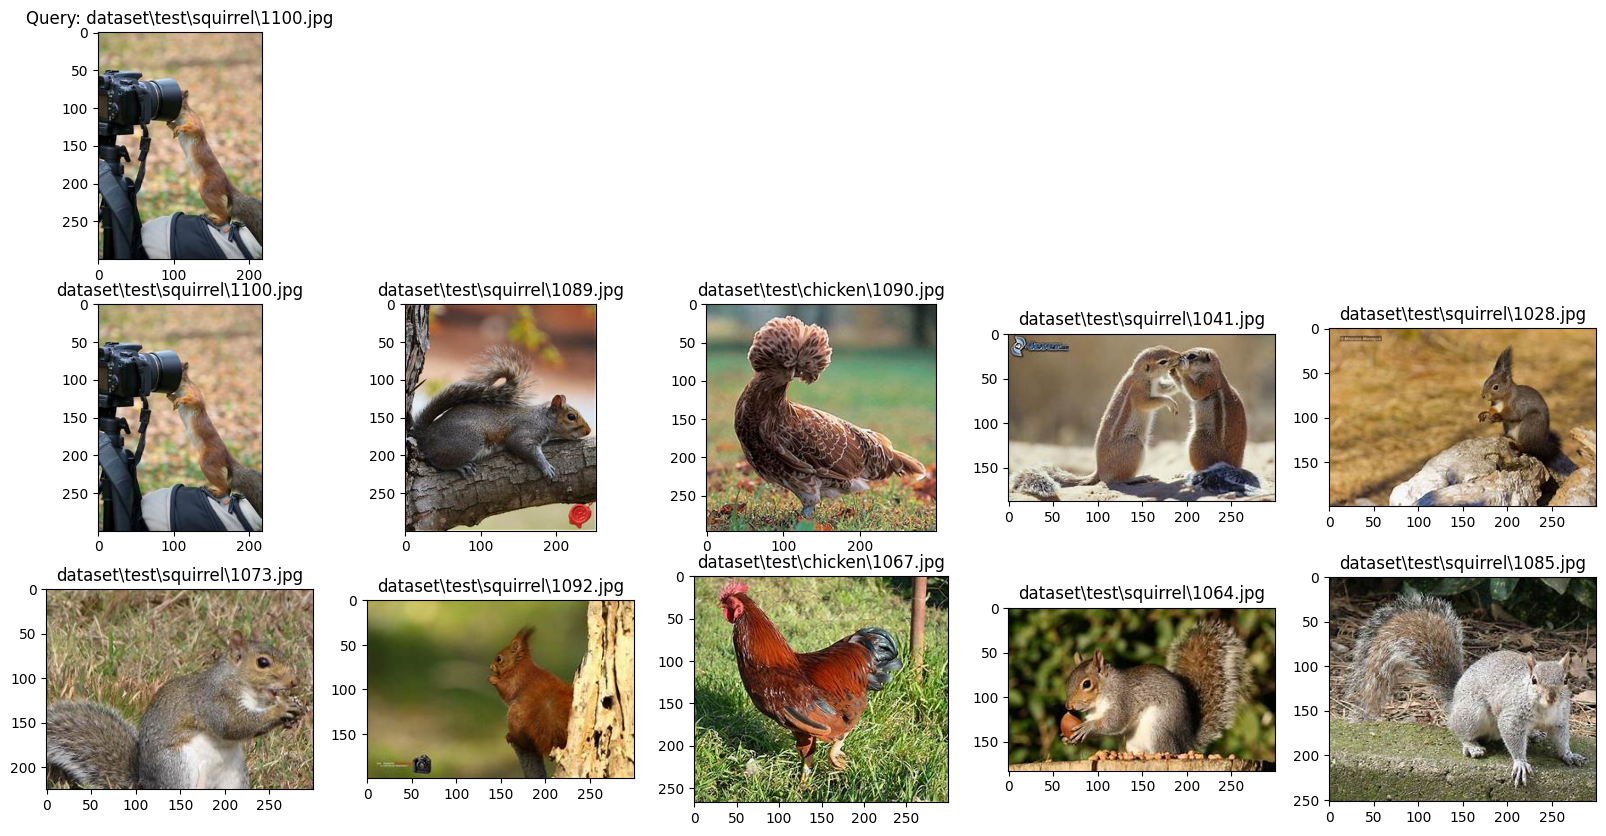

In [19]:
test_image_1, candidates_idx = res[999]
print(test_image_1, candidates_idx)
plot_result(test_image_1, candidates_idx, test_path)